In [1]:
import numpy as np
import pandas as pd
import argparse
from scipy.stats import pearsonr, entropy
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import logomaker
from itertools import cycle
import os
from typing import List
import requests

from ism_utils import mutate_sequence, optimize_csc

from data_module import CodonDataModule
from fine_tuning import PLProteinBertRegressor
from calm.model import ProteinBertRegressor
from calm.alphabet import Alphabet
from calm.pretrained import CaLMTokenizer

In [2]:
data = pd.read_csv('/Users/clark04/toby/CDS-LM/data/human_cds.csv', index_col=0)

In [2]:
data = pd.read_csv('./results/finetuning/saluki_with_preds.csv')

In [3]:
def get_coding_sequence(ensembl_id: str) -> str:
    return data.loc[ensembl_id]['Sequence']

In [9]:
def predict(model, dataloader) -> List[float]:
    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            tokens = batch['input'].to("cuda")  # Move to GPU if available
            preds = model(tokens)  # Forward pass
            preds = preds["logits"].squeeze(-1)  # Extract logits
            predictions.extend(preds.cpu().numpy())
    return predictions

def prep_mutations(sequence: str, mode: str = 'codon', save_dir: str = '.') -> pd.DataFrame:
    '''
    Mutates given sequences, saving possible mutations to a directory for use by the data module.
    Returns a dataframe containing sequences, mutation identity and mutation position for plotting.
    '''
    if len(sequence) > 3 * 1024: # trim sequence to CaLM max input length
        sequence = sequence[:3*1024]
    
    mutation_df = mutate_sequence(sequence, mode=mode)
    display(mutation_df.head())
    seq_df = mutation_df[['sequence', 'position']].copy()
    
    # Add the original sequence to the end of the prediction dataframe
    seq_df.loc[len(seq_df)] = [sequence, -1]
    seq_df.to_csv(f'{save_dir}/tmp.csv')
    
    return mutation_df

def in_silico_mutagenesis(model: PLProteinBertRegressor, args: argparse.Namespace, alphabet: Alphabet, 
                          sequence: str, mode: str = 'codon', tmp_dir: str = '.', batch_size: int = 16) -> pd.DataFrame:
    '''
    Perform in silico mutagenesis on a DNA sequence
    
    Args:
        model: A fine-tuned CaLM regressor.
        sequence (str): The original DNA sequence to mutate.
        mode (str): Whether to perform nucleotide or synonymous codon ISM.
        tmp_dir (str): Directory in which to save tmp file for the data module.
        batch_size (int): Inference batch size for the model (change based on memory constraints).
    
    Returns:
        pd.DataFrame: DataFrame with mutation effects.
    '''
    
    trim_length = len(sequence) - (len(sequence) % 3)
    sequence = sequence[:trim_length]
    
    mutation_df = prep_mutations(sequence, mode, tmp_dir)
    
    split_idxs = (np.array(range(len(mutation_df) + 1)), np.array([1]))
    datamodule = CodonDataModule(args, alphabet, f'{tmp_dir}/tmp.csv',
                                 batch_size, fine_tune=True,
                                 split_idxs =split_idxs, target_column='position')
    datamodule.setup()
    dataloader = datamodule.train_dataloader()
    
    preds = predict(model, dataloader)
    original_prediction = preds[-1] # Retrieve the original prediction from the end of the predictions
    preds = preds[:-1]

    mutation_df["prediction"] = preds
    
    # Calculate the change in prediction
    mutation_df["delta_prediction"] = mutation_df["prediction"] - original_prediction
    
    return mutation_df
    

## Loading CaLM

In [5]:
args = argparse.Namespace(
    max_positions=1024,
    warmup_steps=200,
    weight_decay=0.1,
    lr_scheduler='warmup_cosine',
    learning_rate=1e-4,
    batch_size=4,
    accumulate_gradients=32,
    num_steps=15000,
    num_layers = 12,
    embed_dim = 768,
    attention_dropout = 0.,
    logit_bias = False,
    rope_embedding = True,
    ffn_embed_dim = 768*4,
    attention_heads = 12
)

# Initialize model
alphabet = Alphabet.from_architecture('CodonModel')

base_model = ProteinBertRegressor(args, alphabet)
tokenizer = CaLMTokenizer()

checkpoint_path = f'./assets/crossval/saluki_stability_fold_0.ckpt'
model = PLProteinBertRegressor.load_from_checkpoint(checkpoint_path, model=base_model, args=args)
model.to('cuda')
model.eval()

fig_dir="./figs/saluki_fold_0/"

In [6]:
seq = data['CDS'][303]

In [7]:
# Example for tokenizing single sequences
'''
tokenized_seq = tokenizer(seq)
pred = model(tokenized_seq.to('cuda'))['logits'].squeeze(-1)
pred = pred.detach().cpu().item()
pred
'''

"\ntokenized_seq = tokenizer(seq)\npred = model(tokenized_seq.to('cuda'))['logits'].squeeze(-1)\npred = pred.detach().cpu().item()\npred\n"

In [12]:
ensembl_id = "ENSG00000088038"
sequence = get_coding_sequence(ensembl_id)

In [8]:
mutation_df = in_silico_mutagenesis(model, args, alphabet, seq, tmp_dir='ISM_tmp', mode='codon')

,position,original_codon,mutated_codon,sequence
0,1,GAG,GAA,ATGGAAAGCGAGCGCGACATGTACCGCCAGTTCCAGGACTGGTGCC...
1,2,AGC,TCC,ATGGAGTCCGAGCGCGACATGTACCGCCAGTTCCAGGACTGGTGCC...
2,2,AGC,TCT,ATGGAGTCTGAGCGCGACATGTACCGCCAGTTCCAGGACTGGTGCC...
3,2,AGC,TCG,ATGGAGTCGGAGCGCGACATGTACCGCCAGTTCCAGGACTGGTGCC...
4,2,AGC,TCA,ATGGAGTCAGAGCGCGACATGTACCGCCAGTTCCAGGACTGGTGCC...


In [10]:
mutation_df.sort_values(by='delta_prediction')

,position,original_codon,mutated_codon,sequence,prediction,delta_prediction
65,29,CGT,AGG,ATGGAGAGCGAGCGCGACATGTACCGCCAGTTCCAGGACTGGTGCC...,-0.997992,-0.009051
1106,457,CGT,AGG,ATGGAGAGCGAGCGCGACATGTACCGCCAGTTCCAGGACTGGTGCC...,-0.997907,-0.008965
1105,457,CGT,AGA,ATGGAGAGCGAGCGCGACATGTACCGCCAGTTCCAGGACTGGTGCC...,-0.997628,-0.008687
15,8,CGC,AGG,ATGGAGAGCGAGCGCGACATGTACAGGCAGTTCCAGGACTGGTGCC...,-0.997327,-0.008386
16,8,CGC,CGG,ATGGAGAGCGAGCGCGACATGTACCGGCAGTTCCAGGACTGGTGCC...,-0.997035,-0.008094
...,...,...,...,...,...,...
1074,444,AGG,CGT,ATGGAGAGCGAGCGCGACATGTACCGCCAGTTCCAGGACTGGTGCC...,-0.982180,0.006761
75,34,CGG,CGT,ATGGAGAGCGAGCGCGACATGTACCGCCAGTTCCAGGACTGGTGCC...,-0.981245,0.007696
32,16,AGG,CGC,ATGGAGAGCGAGCGCGACATGTACCGCCAGTTCCAGGACTGGTGCC...,-0.981020,0.007922
31,16,AGG,CGT,ATGGAGAGCGAGCGCGACATGTACCGCCAGTTCCAGGACTGGTGCC...,-0.980481,0.008460


## Visualising Results

### Codon Mutations

In [11]:
genetic_code = {'GAC':'D','GAT':'D','GAA':'E','GAG':'E','GCG':'A','GCT':'A','GCA':'A','GCC':'A','TCC':'S','TCT':'S','TCG':'S','TCA':'S','AGT':'S','AGC':'S','ACA':'T','ACG':'T','ACT':'T','ACC':'T','AAT':'N','AAC':'N',
                 'TGG':'W','TAT':'Y','TAC':'Y','TTT':'F','TTC':'F','TGT':'C','TGC':'C','CTC':'L','CTT':'L','CTA':'L','TTA':'L','TTG':'L','CTG':'L','ATA':'I','ATT':'I','ATC':'I','ATG':'M','GTC':'V','GTT':'V','GTG':'V',
                 'GTA':'V','CAG':'Q','CAA':'Q','AAA':'K','AAG':'K','AGA':'R','AGG':'R','CGG':'R','CGT':'R','CGC':'R','CGA':'R','CAT':'H','CAC':'H','CCG':'P','CCT':'P','CCC':'P','CCA':'P','TGA':' ','TAA':' ','TAG':' ',
                'GGA':'G','GGC':'G','GGG':'G','GGT':'G'}

colour_palette = ['red','blue','green','magenta','yellow','cyan','lime','orange','purple','pink',
    'brown','teal','gold','olive','coral','salmon','indigo','darkgreen', 'turquoise', 'lightgray', 'black']

# Assign colors to amino acids
amino_acid_colours = {}
for aa, colour in zip(set(genetic_code.values()), cycle(colour_palette)):
    amino_acid_colours[aa] = colour

# Create the codon-color map
codon_colour_map = {codon: amino_acid_colours[aa] for codon, aa in genetic_code.items()}

In [12]:
colour_palette = {
    'weblogo_protein':
    {'GCT': 'black', 'GCC': 'black', 'GCA': 'black', 'GCG': 'black', 'TTT': 'black', 'TTC': 'black', 'ATT': 'black', 'ATC': 'black', 'ATA': 'black', 'TTA': 'black', 'TTG': 'black', 'CTT': 'black', 'CTC': 'black', 'CTA': 'black', 'CTG': 'black', 'ATG': 'black', 'CCT': 'black', 'CCC': 'black', 'CCA': 'black', 'CCG': 'black', 'TGG': 'black', 'GTT': 'black', 'GTC': 'black', 'GTA': 'black', 'GTG': 'black', 'TGT': 'lime', 'TGC': 'lime', 'GGT': 'lime', 'GGC': 'lime', 'GGA': 'lime', 'GGG': 'lime', 'TCT': 'lime',
        'TCC': 'lime', 'TCA': 'lime', 'TCG': 'lime', 'AGT': 'lime', 'AGC': 'lime', 'ACT': 'lime', 'ACC': 'lime', 'ACA': 'lime', 'ACG': 'lime', 'TAT': 'lime', 'TAC': 'lime', 'GAT': 'red', 'GAC': 'red', 'GAA': 'red', 'GAG': 'red', 'CAT': 'blue', 'CAC': 'blue', 'AAA': 'blue', 'AAG': 'blue', 'CGT': 'blue', 'CGC': 'blue', 'CGA': 'blue', 'CGG': 'blue', 'AGA': 'blue', 'AGG': 'blue', 'AAT': 'magenta', 'AAC': 'magenta', 'CAA': 'magenta', 'CAG': 'magenta', 'TAA': 'peru', 'TAG': 'gold', 'TGA': 'azure'},
    'charge':
    {'GCT': 'dimgrey', 'GCC': 'dimgrey', 'GCA': 'dimgrey', 'GCG': 'dimgrey', 'TTT': 'dimgrey', 'TTC': 'dimgrey', 'ATT': 'dimgrey', 'ATC': 'dimgrey', 'ATA': 'dimgrey', 'TTA': 'dimgrey', 'TTG': 'dimgrey', 'CTT': 'dimgrey', 'CTC': 'dimgrey', 'CTA': 'dimgrey', 'CTG': 'dimgrey', 'ATG': 'dimgrey', 'CCT': 'dimgrey', 'CCC': 'dimgrey', 'CCA': 'dimgrey', 'CCG': 'dimgrey', 'TGG': 'dimgrey', 'GTT': 'dimgrey', 'GTC': 'dimgrey', 'GTA': 'dimgrey', 'GTG': 'dimgrey', 'TGT': 'dimgrey', 'TGC': 'dimgrey', 'GGT': 'dimgrey', 'GGC': 'dimgrey', 'GGA': 'dimgrey', 'GGG': 'dimgrey', 'TCT': 'dimgrey',
        'TCC': 'dimgrey', 'TCA': 'dimgrey', 'TCG': 'dimgrey', 'AGT': 'dimgrey', 'AGC': 'dimgrey', 'ACT': 'dimgrey', 'ACC': 'dimgrey', 'ACA': 'dimgrey', 'ACG': 'dimgrey', 'TAT': 'dimgrey', 'TAC': 'dimgrey', 'GAT': 'red', 'GAC': 'red', 'GAA': 'red', 'GAG': 'red', 'CAT': 'mediumblue', 'CAC': 'mediumblue', 'AAA': 'mediumblue', 'AAG': 'mediumblue', 'CGT': 'mediumblue', 'CGC': 'mediumblue', 'CGA': 'mediumblue', 'CGG': 'mediumblue', 'AGA': 'mediumblue', 'AGG': 'mediumblue', 'AAT': 'dimgrey', 'AAC': 'dimgrey', 'CAA': 'dimgrey', 'CAG': 'dimgrey', 'TAA': 'peru', 'TAG': 'gold', 'TGA': 'azure'},
    'hydrophobicity':
    {'GCT': 'green', 'GCC': 'green', 'GCA': 'green', 'GCG': 'green', 'TTT': 'black', 'TTC': 'black', 'ATT': 'black', 'ATC': 'black', 'ATA': 'black', 'TTA': 'black', 'TTG': 'black', 'CTT': 'black', 'CTC': 'black', 'CTA': 'black', 'CTG': 'black', 'ATG': 'black', 'CCT': 'green', 'CCC': 'green', 'CCA': 'green', 'CCG': 'green', 'TGG': 'black', 'GTT': 'black', 'GTC': 'black', 'GTA': 'black', 'GTG': 'black', 'TGT': 'black', 'TGC': 'black', 'GGT': 'green', 'GGC': 'green', 'GGA': 'green', 'GGG': 'green', 'TCT': 'green', 'TCC': 'green', 'TCA': 'green', 'TCG': 'green',
        'AGT': 'green', 'AGC': 'green', 'ACT': 'green', 'ACC': 'green', 'ACA': 'green', 'ACG': 'green', 'TAT': 'black', 'TAC': 'black', 'GAT': 'mediumblue', 'GAC': 'mediumblue', 'GAA': 'mediumblue', 'GAG': 'mediumblue', 'CAT': 'green', 'CAC': 'green', 'AAA': 'mediumblue', 'AAG': 'mediumblue', 'CGT': 'mediumblue', 'CGC': 'mediumblue', 'CGA': 'mediumblue', 'CGG': 'mediumblue', 'AGA': 'mediumblue', 'AGG': 'mediumblue', 'AAT': 'mediumblue', 'AAC': 'mediumblue', 'CAA': 'mediumblue', 'CAG': 'mediumblue', 'TAA': 'peru', 'TAG': 'gold', 'TGA': 'azure'},
    'chemistry':
    {'GCT': 'black', 'GCC': 'black', 'GCA': 'black', 'GCG': 'black', 'TTT': 'black', 'TTC': 'black', 'ATT': 'black', 'ATC': 'black', 'ATA': 'black', 'TTA': 'black', 'TTG': 'black', 'CTT': 'black', 'CTC': 'black', 'CTA': 'black', 'CTG': 'black', 'ATG': 'black', 'CCT': 'black', 'CCC': 'black', 'CCA': 'black', 'CCG': 'black', 'TGG': 'black', 'GTT': 'black', 'GTC': 'black', 'GTA': 'black', 'GTG': 'black', 'TGT': 'lime', 'TGC': 'lime', 'GGT': 'lime', 'GGC': 'lime', 'GGA': 'lime', 'GGG': 'lime', 'TCT': 'lime', 'TCC': 'lime', 'TCA': 'lime',
        'TCG': 'lime', 'AGT': 'lime', 'AGC': 'lime', 'ACT': 'lime', 'ACC': 'lime', 'ACA': 'lime', 'ACG': 'lime', 'TAT': 'lime', 'TAC': 'lime', 'GAT': 'red', 'GAC': 'red', 'GAA': 'red', 'GAG': 'red', 'CAT': 'mediumblue', 'CAC': 'mediumblue', 'AAA': 'mediumblue', 'AAG': 'mediumblue', 'CGT': 'mediumblue', 'CGC': 'mediumblue', 'CGA': 'mediumblue', 'CGG': 'mediumblue', 'AGA': 'mediumblue', 'AGG': 'mediumblue', 'AAT': 'purple', 'AAC': 'purple', 'CAA': 'purple', 'CAG': 'purple', 'TAA': 'peru', 'TAG': 'gold', 'TGA': 'azure'},
    'aa': codon_colour_map
}

codon_to_symbol = {'AAA': 'A', 'AAC': 'B', 'AAG': 'C', 'AAT': 'D', 'ACA': 'E', 'ACC': 'F', 'ACG': 'G', 'ACT': 'H',
                'AGA': 'I',
                'AGC': 'J', 'AGG': 'K', 'AGT': 'L', 'ATA': 'M', 'ATC': 'N', 'ATG': 'O', 'ATT': 'P', 'CAA': 'Q',
                'CAC': 'R',
                'CAG': 'S', 'CAT': 'T', 'CCA': 'U', 'CCC': 'V', 'CCG': 'W', 'CCT': 'X', 'CGA': 'Y', 'CGC': 'Z',
                'CGG': '1',
                'CGT': '2', 'CTA': '3', 'CTC': '4', 'CTG': '5', 'CTT': '6', 'GAA': '7', 'GAC': '8', 'GAG': '9',
                'GAT': ';',
                'GCA': ':', 'GCC': '}', 'GCG': '{', 'GCT': '[', 'GGA': ']', 'GGC': '(', 'GGG': ')', 'GGT': '*',
                'GTA': '&',
                'GTC': '$', 'GTG': '%', 'GTT': '@', 'TAA': '#', 'TAC': '-', 'TAG': '=', 'TAT': '+', 'TCA': '/',
                'TCC': '|',
                'TCG': '<', 'TCT': '>', 'TGA': '?', 'TGC': '!', 'TGG': ',', 'TGT': '.', 'TTA': 'ç', 'TTC': '"',
                'TTG': "'",
                'TTT': '_'
                }
alpha_colour = 'aa'#'weblogo_protein', 'charge', 'chemistry', 'hydrophobicity'

In [13]:
def plot_codon_logo(mutation_df: pd.DataFrame, seq_length: int = 20, original_codon: bool = True, multi_pool: str = 'mean',  entropy_thres: float = 6.0) -> bool:
    '''
    Plots a codon logo for a given mutation DataFrame
    multi_pool decides whether to use the maximum change in prediction or mean change in prediction when calculating values for codons with multiple synonymous codons
    '''
    if original_codon:
        if multi_pool == 'max':
            mutation_df['delta_prediction'] = mutation_df['delta_prediction'].abs()
            position_importance = mutation_df.groupby(['position', 'original_codon'])['delta_prediction'].max().reset_index()
        else:    
            position_importance = mutation_df.groupby(['position', 'original_codon'])['delta_prediction'].mean().reset_index()
        position_effects = position_importance.pivot(index='position', columns='original_codon', values='delta_prediction').fillna(0)
    else:
        position_effects = mutation_df.pivot(index='position', columns='mutated_codon', values='delta_prediction').fillna(0)
    
    pos_sum = position_effects.sum(axis=1)
    entropy_value = entropy(pos_sum.abs()/pos_sum.abs().sum())
    print(entropy_value)
    
    effects_dict = position_effects.to_dict('Dict')
    
    
    # DEFINNG GLYPHS PARAMETERS
    info2Glyph = {}
    p=2
    for pos in range(1, seq_length+1):
        # print(f'pos: \n{pos}\n')
        codonbits = {}
        floor = ceiling = 0
        for codon in effects_dict.keys():
            try:
                codonbits[codon] = effects_dict[codon][pos]
            except KeyError:
                codonbits[codon] = 0.0
        if original_codon:
            codonbits_sorted = sorted(
                codonbits.items(), key=lambda x: x[1], reverse=True
            )
            
        else:
            n_codons = sum(1 for value in codonbits.values() if value != 0)
            normalized_codons = {codon: v/n_codons  if n_codons != 0 else 0 for codon, v in codonbits.items()}
            # Sort codons by normalized contributions
            codonbits_sorted = sorted(
                normalized_codons.items(), key=lambda x: x[1], reverse=True
            )
        for codon, bit in codonbits_sorted:
            if bit != 0.0:
                ceiling = floor + abs(bit)  # Stack codons
                if pos not in info2Glyph:
                    info2Glyph[pos] = {codon: {
                        'bit': bit,
                        'p':p,
                        'floor': floor,
                        'ceiling': ceiling,
                        'colour': colour_palette[alpha_colour][codon]
                    }}
                else:
                    info2Glyph[pos][codon] = {
                        'bit': bit,
                        'p':p,
                        'floor': floor,
                        'ceiling': ceiling,
                        'colour': colour_palette[alpha_colour][codon]
                    }
                floor = ceiling
        p+=3


    # removing positions and building list to fill glyphs
    PreListInfo2Glyph = list(info2Glyph.values())
    ListInfo2Glyph = []
    for codons in PreListInfo2Glyph:
        for (key, value) in codons.items():
            ListInfo2Glyph.append({
                'codon': key,
                'data': value,
            })
   
    if entropy_value < entropy_thres:
        x = seq_length/2
        fig, ax = plt.subplots(figsize=[x, 3])
        # set bounding box
        ax.set_xlim([0.5, (seq_length*3) + 0.5])
        ax.set_ylim([0, max(item['data']['ceiling'] for item in ListInfo2Glyph)])


        def generate_glyph(c, p, width, ceiling, ax, floor, color):
            return logomaker.Glyph(c=c,
                         p=p,
                         width=width,
                         ceiling=ceiling,
                         ax=ax,
                         floor=floor,
                         color=color)


        list(
            map(
                lambda item:
                generate_glyph(
                    c=item['codon'],
                    p=item['data']['p'],
                    width=3.0,
                    ceiling=item['data']['ceiling'],
                    ax=ax,
                    floor=item['data']['floor'],
                    color=item['data']['colour']),
                ListInfo2Glyph
            )
        )

        title = 'logo plot'
        ax.set_title(title)
        ax.set_xlabel('length')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_ylabel('delta_prediction')
        
        return True
    
    return False

6.229865582442279


True

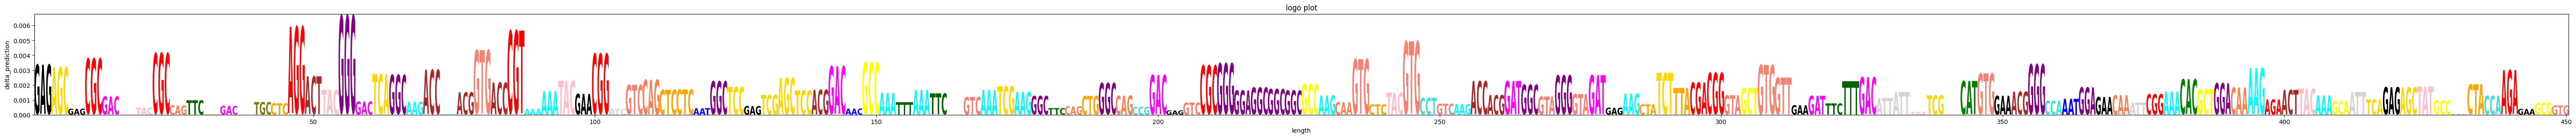

In [18]:
plot_codon_logo(mutation_df, seq_length=150, original_codon=True, multi_pool='mean', entropy_thres=7)

### Nucleotide mutations

In [151]:
mutation_df.sort_values(by='delta_prediction', ascending=True).head(n=10)

,position,original_codon,mutated_codon,codon_sequence,prediction,delta_prediction
2424,904,GCG,GCT,ATG GAG GGC GGC GAG TCC ACG GAG TCC ACA CAC AA...,47.639187,0.000004
2547,944,TCC,AGC,ATG GAG GGC GGC GAG TCC ACG GAG TCC ACA CAC AA...,47.639202,0.000011
1759,669,AGT,AGC,ATG GAG GGC GGC GAG TCC ACG GAG TCC ACA CAC AA...,47.639214,0.000023
1307,498,CCC,CCT,ATG GAG GGC GGC GAG TCC ACG GAG TCC ACA CAC AA...,47.639156,0.000034
2658,980,CGG,CGC,ATG GAG GGC GGC GAG TCC ACG GAG TCC ACA CAC AA...,47.639240,0.000050
2989,1112,TCC,TCG,ATG GAG GGC GGC GAG TCC ACG GAG TCC ACA CAC AA...,47.639244,0.000053
30,13,AAG,AAA,ATG GAG GGC GGC GAG TCC ACG GAG TCC ACA CAC AA...,47.639252,0.000061
2146,808,AGC,TCT,ATG GAG GGC GGC GAG TCC ACG GAG TCC ACA CAC AA...,47.639122,0.000069
2311,867,GGA,GGT,ATG GAG GGC GGC GAG TCC ACG GAG TCC ACA CAC AA...,47.639263,0.000072
3096,1156,AGC,TCG,ATG GAG GGC GGC GAG TCC ACG GAG TCC ACA CAC AA...,47.639263,0.000072


In [25]:
def plot_nucleotide_logo(mutation_df, entropy_thres=11.0):
    
    position_importance = mutation_df.groupby(['position', 'original_base'])['delta_prediction'].sum().reset_index()
    position_importance_matrix = position_importance.pivot(index='position', columns='original_base', values='delta_prediction').fillna(0)  
    
    position_effects = mutation_df.pivot(index='position', columns='mutated_base', values='delta_prediction').fillna(0)
    position_effects = position_effects[['A', 'C', 'G', 'T']]
    
    p_importance = position_effects.sum(axis=1)
    norm_p_importance = p_importance.abs()/p_importance.abs().sum()
    entropy_value = entropy(norm_p_importance, base=2)
    print(norm_p_importance.sum())
    print(p_importance.abs().sum())
    print(entropy_value)

    if entropy_value < entropy_thres:
        fig, ax = plt.subplots(figsize=(10, 3))
        logo = logomaker.Logo(position_effects.iloc[:100], ax=ax)
        logo.style_glyphs(shade_below_zero=True, fade_below_zero=True)
        logo.style_xticks(anchor=-1, spacing=5, rotation=0)
        ax.set_xlabel("Nucleotide position")
        ax.set_ylabel(f"$\Delta Stability$")
        plt.tight_layout()

        color_scheme = {'A': 'green', 'C': 'blue', 'G': 'orange', 'T': 'red'}
        fig, ax = plt.subplots(figsize=(10, 3))
        logo = logomaker.Logo(-position_importance_matrix.iloc[:100], color_scheme=color_scheme, ax=ax)
        logo.style_xticks(anchor=-1, spacing=5, rotation=0)
        ax.set_xlabel("Nucleotide position")
        ax.set_ylabel(f"Average $\Delta Stability$")
        plt.tight_layout()
        
        return True
    
    return False

1.0
17.483086
10.327032500720508


True

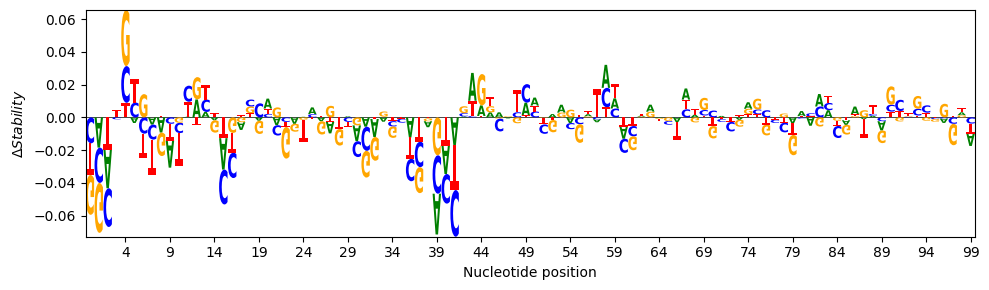

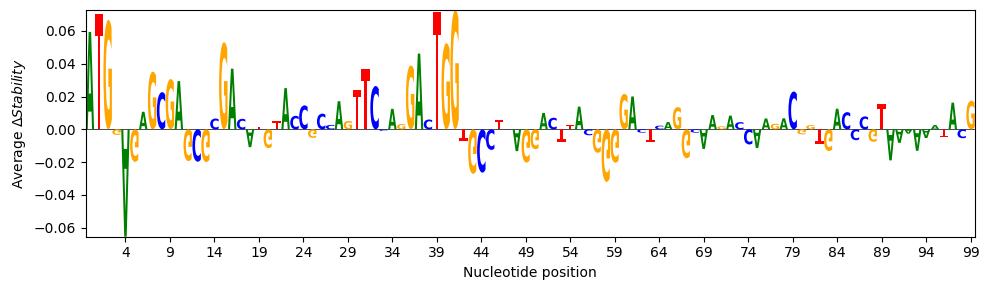

In [26]:
plot_nucleotide_logo(mutation_df)